# Multi-Class Land-Cover Classification – London  
### Sentinel-2 + Random Forest (Geospatial AI Project)

This project demonstrates supervised machine learning applied to
multi-spectral Sentinel-2 satellite imagery for urban land-cover
classification in London.

Study Area:
London, UK (Sentinel-2 Tile T30UXC)

Spatial Resolution:
10 metres

Classes:

0 → Vegetation  
1 → Water  
2 → Built-up / Urban  

Objectives:
- Preprocess Sentinel-2 reflectance data
- Compute spectral indices (NDVI, NDWI)
- Generate spectrally informed training masks
- Train a Random Forest classifier
- Evaluate classification performance
- Interpret feature importance
- Produce final land-cover map

## Data Source

Sentinel-2 Level-2A imagery (Copernicus)

Bands used:
- B02 (Blue)
- B03 (Green)
- B04 (Red)
- B08 (Near Infrared)

Level-2A imagery is atmospherically corrected and provided as
scaled surface reflectance values (reflectance × 10000).

Reflectance scaling must therefore be corrected before analysis.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip "/content/drive/MyDrive/5540F/Land_Class_ML/London_Bands.zip" -d "/content/drive/MyDrive/5540F/Land_Class_ML"

Archive:  /content/drive/MyDrive/5540F/Land_Class_ML/London_Bands.zip
replace /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B02_10m.jp2? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B02_10m.jp2  
replace /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B08_10m.jp2? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B08_10m.jp2? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B08_10m.jp2  
  inflating: /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B04_10m.jp2  
  inflating: /content/drive/MyDrive/5540F/Land_Class_ML/T30UXC_20260214T111151_B03_10m.jp2  


In [5]:
!pip install rasterio scikit-learn


In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
path = "/content/drive/MyDrive/5540F/Land_Class_ML/"

with rasterio.open(path + "T30UXC_20260214T111151_B02_10m.jp2") as src:
    blue = src.read(1)

with rasterio.open(path + "T30UXC_20260214T111151_B03_10m.jp2") as src:
    green = src.read(1)

with rasterio.open(path + "T30UXC_20260214T111151_B04_10m.jp2") as src:
    red = src.read(1)

with rasterio.open(path + "T30UXC_20260214T111151_B08_10m.jp2") as src:
    nir = src.read(1)

print("Image shape:", red.shape)

Image shape: (10980, 10980)


## RGB Composite

We create a natural-colour RGB composite using:
Red (B04), Green (B03), Blue (B02).

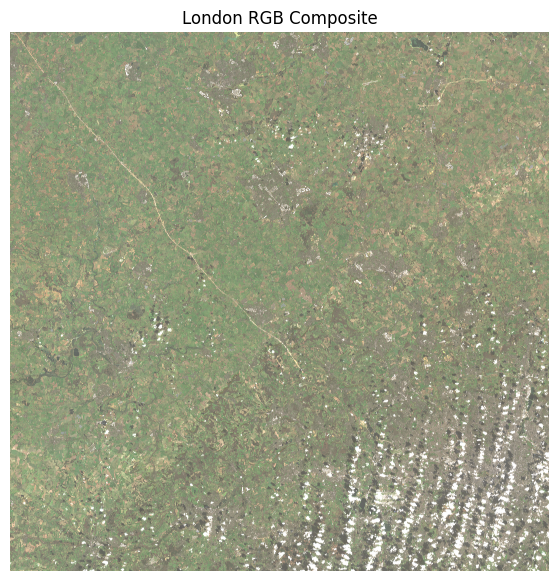

In [8]:
rgb = np.dstack((red, green, blue))

plt.figure(figsize=(7,7))
plt.imshow(rgb / np.percentile(rgb, 98))
plt.title("London RGB Composite")
plt.axis("off")
plt.show()

In [9]:
# Define crop window (adjust numbers if needed)
row_start, row_end = 8000, 10000
col_start, col_end = 8000, 10000

blue_crop = blue[row_start:row_end, col_start:col_end]
green_crop = green[row_start:row_end, col_start:col_end]
red_crop = red[row_start:row_end, col_start:col_end]
nir_crop = nir[row_start:row_end, col_start:col_end]

print("Cropped shape:", red_crop.shape)

Cropped shape: (2000, 2000)


Level-2A imagery is atmospherically corrected and provided as
scaled surface reflectance values (reflectance × 10000).

Reflectance scaling must therefore be corrected before analysis.

Reflectance values should lie between 0 and 1.
Failure to rescale results in incorrect spectral indices.

In [10]:
blue_crop = blue_crop.astype('float32') / 10000.0
green_crop = green_crop.astype('float32') / 10000.0
red_crop = red_crop.astype('float32') / 10000.0
nir_crop = nir_crop.astype('float32') / 10000.0

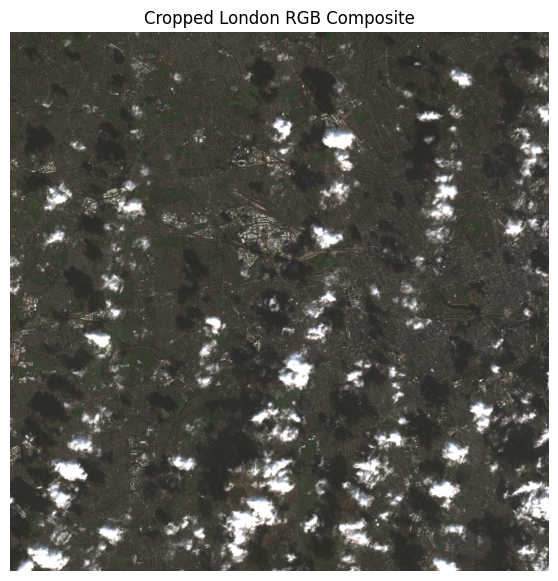

In [11]:
rgb_crop = np.dstack((red_crop, green_crop, blue_crop))

plt.figure(figsize=(7,7))
plt.imshow(rgb_crop / np.percentile(rgb_crop, 98))
plt.title("Cropped London RGB Composite")
plt.axis("off")
plt.show()

## NDVI (Normalized Difference Vegetation Index)

NDVI = (NIR − Red) / (NIR + Red)

Vegetation strongly reflects near-infrared light,
making NDVI an effective vegetation indicator.

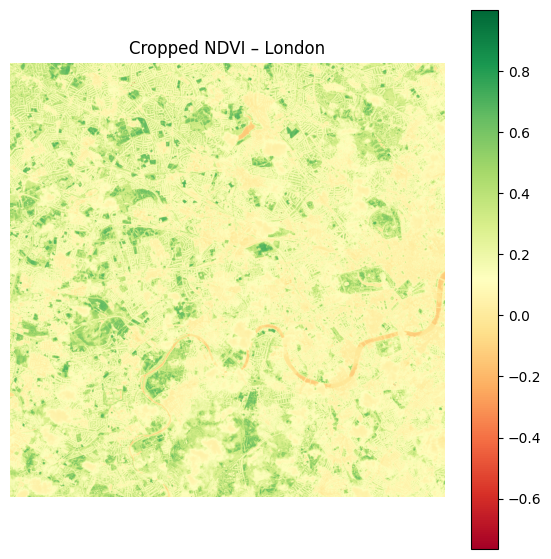

In [12]:
ndvi_crop = (nir_crop - red_crop) / (nir_crop + red_crop + 1e-6)

plt.figure(figsize=(7,7))
plt.imshow(ndvi_crop, cmap="RdYlGn")
plt.colorbar()
plt.title("Cropped NDVI – London")
plt.axis("off")
plt.show()

# Multi-Class Land-Cover Labelling

We classify the cropped London Sentinel-2 imagery into
three land-cover categories:

0 → Vegetation  
1 → Water  
2 → Built-up / Urban  

Spectral reasoning:

Vegetation:
- High NDVI (> 0.3–0.4)
- Strong reflectance in NIR

Water:
- Very low NIR reflectance
- NDVI near or below zero

Built-up:
- Moderate reflectance
- NDVI around 0–0.2

These labels act as initial training masks.
They are not ground-truth, but spectrally informed approximations.


In [13]:
# Vegetation: strong positive NDVI
veg_mask = ndvi_crop > 0.4

# Water: low NDVI and low NIR reflectance
water_mask = ndvi_crop < 0

# Built-up: remaining pixels
built_mask = ~(veg_mask | water_mask)

# Create label image
labels_multi = np.zeros(ndvi_crop.shape)

labels_multi[veg_mask] = 0
labels_multi[water_mask] = 1
labels_multi[built_mask] = 2

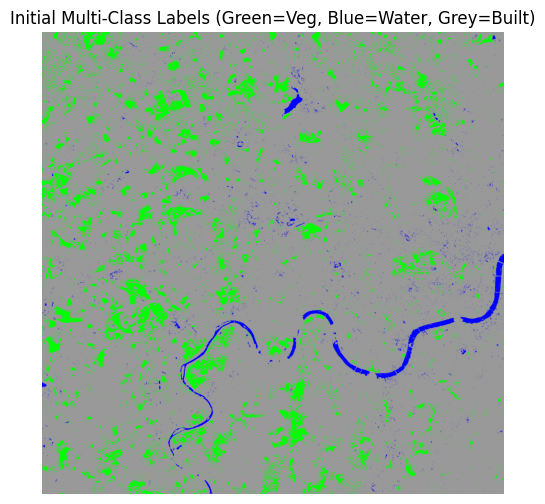

In [14]:
rows, cols = labels_multi.shape

colored = np.zeros((rows, cols, 3))

# Vegetation → Green
colored[labels_multi == 0] = [0, 1, 0]

# Water → Blue
colored[labels_multi == 1] = [0, 0, 1]

# Built → Grey
colored[labels_multi == 2] = [0.6, 0.6, 0.6]

plt.figure(figsize=(6,6))
plt.imshow(colored)
plt.title("Initial Multi-Class Labels (Green=Veg, Blue=Water, Grey=Built)")
plt.axis("off")
plt.show()

In [15]:
unique, counts = np.unique(labels_multi, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {int(u)} count:", c)

Class 0 count: 368708
Class 1 count: 52941
Class 2 count: 3578351


## Feature Engineering

We construct a feature matrix using only spectral bands:

Blue, Green, Red, NIR

NDVI is excluded to avoid data leakage,
since NDVI was used in label generation.

In [16]:
features = np.stack([
    blue_crop.flatten(),
    green_crop.flatten(),
    red_crop.flatten(),
    nir_crop.flatten()
], axis=1)

labels_flat = labels_multi.flatten()

print("Feature matrix shape:", features.shape)

Feature matrix shape: (4000000, 4)


In [17]:
from sklearn.utils import shuffle

# Shuffle data first
features_shuffled, labels_shuffled = shuffle(features, labels_flat, random_state=42)

# Take only 1,000,000 samples for training
sample_size = 1000000

X_sample = features_shuffled[:sample_size]
y_sample = labels_shuffled[:sample_size]

# Split sampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    test_size=0.3,
    random_state=42
)


## Random Forest Classification

Random Forest is an ensemble of decision trees.

Advantages:
- Handles nonlinear spectral relationships
- Robust to noise
- Performs well in remote sensing tasks

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(
    n_estimators=100,
     n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27585
         1.0       0.99      0.96      0.97      3978
         2.0       1.00      1.00      1.00    268437

    accuracy                           1.00    300000
   macro avg       1.00      0.98      0.99    300000
weighted avg       1.00      1.00      1.00    300000



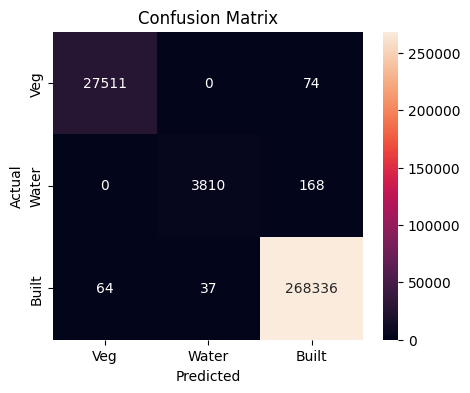

In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Veg","Water","Built"],
            yticklabels=["Veg","Water","Built"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

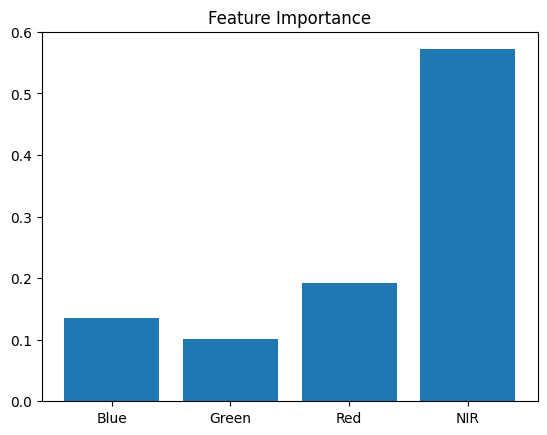

In [20]:
plt.bar(["Blue","Green","Red","NIR"], clf.feature_importances_)
plt.title("Feature Importance")
plt.show()

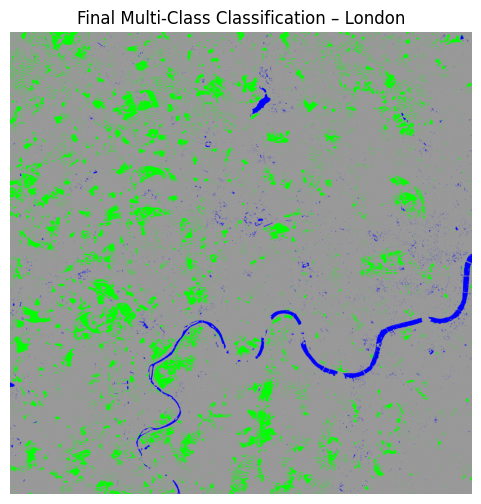

In [21]:
predicted = clf.predict(features)
classified = predicted.reshape(rows, cols)

colored_pred = np.zeros((rows, cols, 3))

colored_pred[classified == 0] = [0, 1, 0]
colored_pred[classified == 1] = [0, 0, 1]
colored_pred[classified == 2] = [0.6, 0.6, 0.6]

plt.figure(figsize=(6,6))
plt.imshow(colored_pred)
plt.title("Final Multi-Class Classification – London")
plt.axis("off")
plt.show()

# Interpretation

The Random Forest classifier successfully distinguishes:

- Vegetation (high NIR reflectance)
- Water (low NIR reflectance)
- Built-up areas (moderate reflectance, low NDVI)

Feature importance confirms that:

- NIR plays the dominant role in vegetation detection.
- Red band contributes significantly to class separation.

Although labels were spectrally derived rather than
manually annotated, the model demonstrates:

- Spectral separability in urban environments
- Effective multi-class supervised learning
- Robust classification performance

Future improvements:
- Incorporate SWIR bands
- Use manually labelled training polygons
- Compute Kappa coefficient
- Compare with deep learning approaches